# Appliances Energy Forecasting

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote, unquote
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Import libraries for the model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Selecting Data Columns
* Tag names are loaded in sequential order.
* The process of selecting the required tag names from the tag name list.

In [2]:
# Function to display tag names
def show_column(URL):
    
    # Load tag name data
    df = pd.read_csv(URL)
    
    # Convert to list format
    df = df.values.reshape(-1)
    
    return df.tolist()

In [3]:
## Set parameters for displaying tag names
table = 'appliance_energy'

NAME_URL = f'http://127.0.0.1:5654/db/tql/datahub/api/v1/get-tag-names.tql?table={table}'

## Generate tag name list
name = show_column(NAME_URL)

In [4]:
name

['Appliances',
 'Press_mm_hg',
 'RH_1',
 'RH_2',
 'RH_3',
 'RH_4',
 'RH_5',
 'RH_6',
 'RH_7',
 'RH_8',
 'RH_9',
 'RH_out',
 'T1',
 'T2',
 'T3',
 'T4',
 'T5',
 'T6',
 'T7',
 'T8',
 'T9',
 'T_out',
 'Tdewpoint',
 'Visibility',
 'Windspeed',
 'lights',
 'rv1',
 'rv2']

## Converting TAG Name Format
* After checking all the Tag Names from the Appliances Energy dataset in the previous step, extract only the columns to be used and convert them into parameter format.
* Use Appliances tag name

In [5]:
# Set the desired tag names
tags = name[:1]

# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)

# Check the selected tag names
print(tags_)

'Appliances'


## Load Appliances Energy Dataset
* Load the data using all tag name

In [6]:
# Data loading function
def data_load(table, name, start_time, end_time, timeformat):
    
    # Load data 
    df = pd.read_csv(f'http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}')

    # Convert to data grouped by the time
    df = df.pivot_table(index='TIME', columns='NAME', values='VALUE', aggfunc='first').reset_index()

    # Set TIME column
    df['TIME'] = pd.to_datetime(df['TIME'])
    
    # Set time index
    df.set_index('TIME', inplace=True)
    
    # Time series decomposition
    decomposition = seasonal_decompose(df['Appliances'], model='additive', period=24)

    # Use only the trend
    trend = decomposition.trend 
    
    # Create a new DataFrame
    df = pd.DataFrame(trend.dropna().values, columns=['value'])
    df.index = trend.dropna().index
    
    # Create new columns with window applied
    df['lag1'] = df['value'].shift(1)  # Previous 10-min data
    df['lag2'] = df['value'].shift(2)  # Previous 20-min data
    df['lag3'] = df['value'].shift(3)  # Previous 30-min data 
    df['lag4'] = df['value'].shift(4)  # Previous 40-min data 
    
    # Remove missing values
    df = df.dropna()
    
    # Move 'value' column to the end
    df['value'] = df.pop('value')
     
    return df

In [7]:
# Data time loading function
def time_data_load(table, name, start_time, end_time, timeformat):
    
    target = 'time'
    
    # Load the data
    df = pd.read_csv(f"http://127.0.0.1:5654/db/tql/datahub/api/v1/select-rawdata.tql?target={target}&table={table}&name={name}&start={start_time}&end={end_time}&timeformat={timeformat}")
    
    # Create a dummy value column for resampling
    df['value'] = 0
    
    # Perform resampling
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    # Determine resampling units based on the data and perform resampling
    df = df.resample('1T').mean()
    
    # Remove missing values
    df = df.dropna()
    
    # Remove the dummy value column
    df = df.drop(['value'], axis=1)
    
    return df

In [8]:
# Time update function
# Update start and end times based on batch size
def update_time(time_df, start_time, batch_size):
    
    # Calculate how many data points need to be loaded
    time = batch_size
    
    # Check the index number of the current time
    # If not found, set to the first index as there is no data for the current time
    try:
        index_now = time_df.index.get_loc(start_time)
    except KeyError:
        index_now = 0
    
    # Set the end time for the batch data based on the current time 
    end_time_ = str(time_df.index[index_now + time] + timedelta(seconds=1))
    
    # Set the index number for the next start time
    index_next = index_now + time
    
    # Set the next start time
    next_start_time_ = str(time_df.index[index_next])
    
    # URL encoding
    start_time_ = quote(start_time)
    end_time_ = quote(end_time_)
    next_start_time_ = quote(next_start_time_)
    
    return start_time_, end_time_, next_start_time_, index_next

## Model Configuration
* Using BILSTM model.

In [9]:
# BILSTM Model Configuration
class BILSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,dropout=0.2, bidirectional=False):
        super(BILSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)
        
        self.lstm2 = nn.LSTM(2*hidden_size, 2*hidden_size, num_layers, 
                    batch_first=True,dropout=dropout, bidirectional=bidirectional)
        
        self.fc = nn.Linear(2* hidden_size * (2 if bidirectional else 1), 1)
        
        self.layer_norm = nn.LayerNorm(3)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm1(x)
        out, (h_n, c_n) = self.lstm2(out)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
# Model configuration parameters

# number of input data columns
input_dim = 4

# BILSTM hidden state size
hidden_dim = 64

# layer size
num_layers = 2

# Learning rate
learning_rate = 0.01

# Model configuration
model = BILSTM(input_dim, hidden_dim, num_layers, bidirectional=True).to(device)

# Configure loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

BILSTM(
  (lstm1): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (lstm2): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (layer_norm): LayerNorm((3,), eps=1e-05, elementwise_affine=True)
)


## Model Training
* Proceed by loading only the necessary batch size of data for training.
* Save the model with the best loss based on the validation data during training.

In [11]:
# Model training function
def train(table, name, timeformat, model, batch_size, epochs, scaler_data, scaler_target, time_df_train):
    
    # Initialize training loss
    train_loss = []

    # Initialize best loss value
    best_Loss = np.inf

    for epoch in epochs:
        
        # Set the model to training mode
        model.train()
        
        # Initialize loss and total step
        running_loss = 0.0
        total_step = 0
        
        # Set initial start time
        start_time_ = str(time_df_train.index[0])
        
        # Set end time
        end_time_train = str(time_df_train.index[-1])
        
        # Use a while loop to call data 
        while start_time_ < end_time_train:
            
            # Set the time for loading data based on the batch size
            start_time_, end_time_, next_start_time_, index_next = update_time(time_df_train, start_time_, batch_size)
        
            # Load batch data
            data = data_load(table, name, start_time_, end_time_, timeformat)
  
            # Apply MinMax scaler
            data_scaled = scaler_data.fit_transform(data.iloc[:, :-1])
            target_scaled = scaler_target.fit_transform(data.iloc[:, -1:])
            
            # Set each DataFrames
            train = pd.DataFrame(data_scaled)  
            train['target'] = target_scaled

            # Print if the loaded data is empty
            if len(train) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(train) == batch_size- 27:

                # Check total batch count
                total_step += 1
                
                # Convert data to numpy arrays
                input_data = np.array(train.iloc[:, :-1])
                input_target = np.array(train.iloc[:, -1:])
                
                # Convert data to Tensor
                input_data = torch.tensor(input_data, dtype=torch.float32).to(device).float()
                input_target = torch.tensor(input_target, dtype=torch.float32).to(device).float()
                
                # Optimize the optimizer
                optimizer.zero_grad()
                
                # Input to the model
                outputs = model(input_data.unsqueeze(1))
        
                # Calculate loss
                loss = criterion(outputs, input_target)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                
                # Reset batch data
                train = 0
                
            # Set the next start time
            start_time_ = unquote(next_start_time_)
                
            # Prevent fetching beyond the last time
            if index_next + batch_size + 27 >= len(time_df_train):
                break
            
        # Print training loss
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')
        
        # Save the model if it has the best loss
        if best_Loss > np.mean(train_loss):
            best_Loss = np.mean(train_loss)
            torch.save(model, f'./result/Appliance_Energy_New_Batch.pt')
            print('Model saved')
        epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
        
    return model, scaler_data, scaler_target

In [12]:
########################################### Training Parameter Settings ################################################
# Set the tag table name
table = 'appliance_energy'
# Set tag name
name = quote(tags_, safe=":/")
# Set time format
timeformat = 'default'
# Set the start time for the train data
start_time_train = '2016-01-11 17:00:00'
# Set the end time for the train data
end_time_train = '2016-04-30 23:50:00'
# Set batch size considering train data dropped during preprocessing
batch_size = 64 + 27
# Set number of epochs
epochs = trange(100, desc='training')
# Set scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()
# Load training time list
time_df_train = time_data_load(table, name, quote(start_time_train), quote(end_time_train), timeformat)

########################################### Proceed with training ################################################
model, scaler_data, scaler_target  = train(table, name, timeformat, model, batch_size, epochs, scaler_data, scaler_target, time_df_train)

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.017893868903950626
Model saved

train loss: 0.011260800534289265
Model saved

train loss: 0.008800672457593143
Model saved

train loss: 0.007561408328032923
Model saved

train loss: 0.006737167829776118
Model saved

train loss: 0.006099875993379686
Model saved

train loss: 0.005662615397506912
Model saved

train loss: 0.005324581109760757
Model saved

train loss: 0.0050340286243400955
Model saved

train loss: 0.004783310934609529
Model saved

train loss: 0.004564040830914664
Model saved

train loss: 0.00438171041156705
Model saved

train loss: 0.004218098897907194
Model saved

train loss: 0.004071517803177486
Model saved

train loss: 0.0039437151258526785
Model saved

train loss: 0.0038265447407667677
Model saved

train loss: 0.0037279469316445564
Model saved

train loss: 0.0036340301239215244
Model saved

train loss: 0.0035521384211193645
Model saved

train loss: 0.003466730371396754
Model saved

train loss: 0.003392822989633328
Model saved

train loss: 0.00332490942728

## Model Testing

In [13]:
# Model testing function
def test(table, name, timeformat, model, batch_size, scaler_data, scaler_target, time_df_test):
    
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
            
        # Set the initial start time
        start_time_t = str(time_df_test.index[0])
        
        # Set the end time
        end_time_test = str(time_df_test.index[-1])
        
        # Use a while loop to call data  
        while start_time_t < end_time_test:
            
            # Set the time for loading data based on the batch size
            start_time_t, end_time_t, next_start_time_t, index_next_t = update_time(time_df_test, start_time_t, batch_size)
            
            # Load batch data
            data_t = data_load(table, name, start_time_t, end_time_t, timeformat)

            # Apply MinMax scaler 
            data_scaled_t = scaler_data.fit_transform(data_t.iloc[:,:-1])
            target_scaled_t = scaler_target.fit_transform(data_t.iloc[:,-1:])
            
            # Set each DataFrames
            test = pd.DataFrame(data_scaled_t)  
            test['target'] = target_scaled_t
            
            # Print if the loaded data is empty
            if len(test) == 0:
                print("No data available.")
            
            # Input the data into the model when it accumulates to the batch size
            if len(test) == batch_size - 27:
                
                # Convert data to numpy arrays
                input_data_t = np.array(test.iloc[:, :-1])
                input_target_t = np.array(test.iloc[:, -1:])

                # Convert data to Tensor
                input_data_t = torch.tensor(input_data_t, dtype=torch.float32).to(device).float()
                input_target_t = torch.tensor(input_target_t, dtype=torch.float32).to(device).float()
                
                # Input to the model
                outputs_t = model(input_data_t.unsqueeze(1))
                
                output_test.append(outputs_t)
                output_target.append(input_target_t)
                
                # Reset batch data
                test = 0

            # Set the next start time   
            start_time_t = unquote(next_start_time_t)
            
            # Prevent fetching beyond the last time
            if index_next_t + batch_size + 27 >= len(time_df_test):
                break
            
        # Combine tensors into one
        combined_tensor = torch.cat(output_test, dim=0)
        combined_target = torch.cat(output_target, dim=0)

        # Use only the last value of the window
        last_values = combined_tensor[:, -1].cpu()
        last_target = combined_target[:, -1].cpu()

        # Create a DataFrame for the results
        final_scaled = pd.DataFrame(last_target, columns=['real'])
        final_scaled['pred'] = last_values

        # Inverse transform using MinMaxScaler 
        last_values_ = scaler_target.inverse_transform(last_values.reshape(-1, 1))
        last_target_ = scaler_target.inverse_transform(last_target.reshape(-1, 1))

        # Create a DataFrame for the results
        final= pd.DataFrame(last_target_, columns=['real'])
        final['pred'] = last_values_
        
    return final_scaled, final 
        

In [14]:
########################################### Test Parameter Settings ################################################
# Load the best model
model_ = torch.load(f'./result/Appliance_Energy_New_Batch.pt')
# Set the start time for the test data
start_time_test = '2016-05-01 00:00:00'
# Set the end time for the test data
end_time_test = '2016-06-01 00:00:00'
# Set the batch size considering the test data dropped during preprocessing
batch_size = 64 + 27
# Load the test time list
time_df_test = time_data_load(table, name, quote(start_time_test), quote(end_time_test), timeformat)
######################################## Proceed with testing #############################################
final_scaled, final = test(table, name, timeformat, model_, batch_size, scaler_data, scaler_target, time_df_test)

## Model Performance Evaluation

In [15]:
# Calculate MSE
mse = mean_squared_error(final['real'].values, final['pred'].values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(final['real'].values, final['pred'].values)
print("R² Score:", r2)

Mean Squared Error: 31.82815158380019
R² Score: 0.9931825203079427


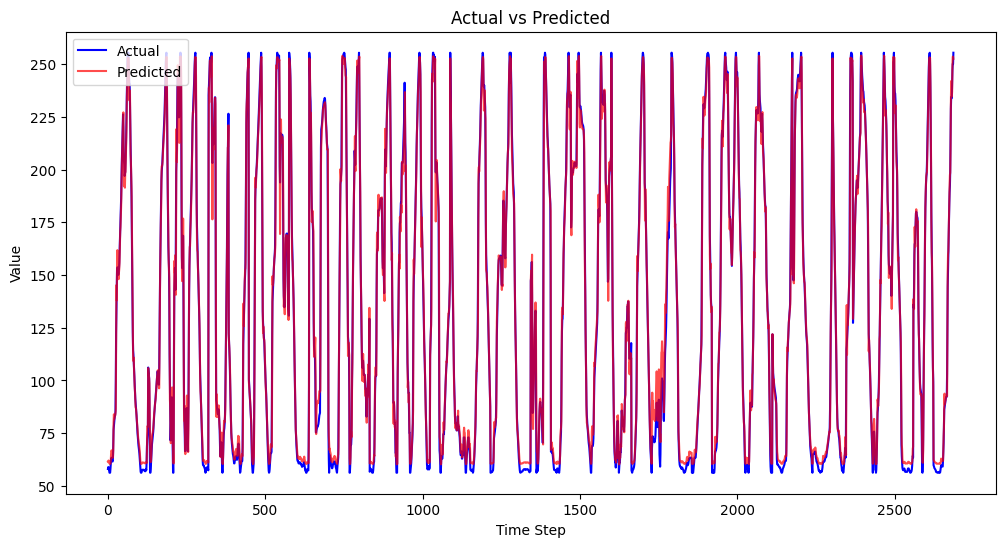

In [16]:
# Compare the test results: Actual values vs Predicted values
plt.figure(figsize=(12, 6))
plt.plot(final['real'].values, label='Actual', color='blue')
plt.plot(final['pred'].values, label='Predicted', color='red', alpha=0.7)
plt.title('Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()